<a href="https://colab.research.google.com/github/danielBejar/Counting_vehicles_with_roboflow_libraries/blob/main/Counting_vehicles_with_roboflow_libraries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# YOLOv8 Tracking and Counting

---

[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/OS5qI9YBkfk)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-tracking-and-counting/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/notebooks)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## ⚠️ Disclaimer

This notebook uses legacy versions of ByteTrack and Supervision. To be up to date, use our updated [notebook](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8-and-supervison.ipynb).

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the [blog post](https://blog.roboflow.com/yolov8-tracking-and-counting/) on how to train YOLOv8 Tracking and Counting, concurrently.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Download video
- Install YOLOv8
- Install ByteTrack
- Install Roboflow Supervision
- Tracking utils
- Load pre-trained YOLOv8 model
- Predict and annotate single frame
- Predict and annotate whole video

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Apr  3 13:28:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **23.01.2023** with version **YOLOv8.0.17**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [ ]:
# Pip install method (recommended)

!pip install "ultralytics<=8.3.40"

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.9/112.6 GB disk)


## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
import sys
sys.path.append('/content/video')
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks

    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack],
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

        # Si el número de frames alcanza reset_every, reiniciamos los IDs


    return tracker_ids

## Download video

In [ ]:

import gdown #pip install gdown

#https://drive.google.com/file/d/1Pz0qm8_HA1pEoEiJEKGPYahkk9VX8nfa/view?usp=sharing

# ID del archivo de Google Drive
file_id = '1Pz0qm8_HA1pEoEiJEKGPYahkk9VX8nfa'
download_url = f'https://drive.google.com/uc?id={file_id}'

# Ruta donde se guardará el archivo ZIP descargado
zip_path = '/content/video.zip'


# Descargar el archivo
gdown.download(download_url, zip_path, quiet=False, fuzzy=True)

!unzip -o /content/video.zip -d /content/


Downloading...
From (original): https://drive.google.com/uc?id=1Pz0qm8_HA1pEoEiJEKGPYahkk9VX8nfa
From (redirected): https://drive.google.com/uc?id=1Pz0qm8_HA1pEoEiJEKGPYahkk9VX8nfa&confirm=t&uuid=d0c143b9-48f4-4976-b498-cd3e5e7a549c
To: /content/video.zip
100%|██████████| 423M/423M [00:14<00:00, 28.7MB/s]


Archive:  /content/video.zip
   creating: /content/video/
  inflating: /content/video/videovehiculos.mp4  


In [ ]:
!unzip -o /content/video.zip -d /content/

Archive:  /content/video.zip
  inflating: /content/video/videovehiculos.mp4  


In [ ]:
import os
print(os.path.exists('/content/video/videovehiculos.mp4'))

!file /content/video.zip



True
/content/video.zip: Zip archive data, at least v2.0 to extract, compression method=store


In [ ]:
SOURCE_VIDEO_PATH = f"/content/video/videovehiculos.mp4"
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=2604)

## Load pre-trained YOLOv8 model

In [ ]:
from ultralytics import YOLO
# settings
MODEL = "/content/best.pt"

model = YOLO(MODEL)
model.fuse()

YOLO11l summary (fused): 464 layers, 25,285,480 parameters, 0 gradients, 86.6 GFLOPs


## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0,1,2,3,4,5,6,7]

# Obtener los nombres de las clases de
class_names = [CLASS_NAMES_DICT[i] for i in CLASS_ID]

# Mostrar los nombres
print("Clases:", class_names)

Clases: ['moto', 'auto', 'pickup', 'colectivo', 'camion_simple', 'camion_doble', 'semi_remolque', 'otro']



0: 384x640 (no detections), 82.4ms
Speed: 18.8ms preprocess, 82.4ms inference, 105.8ms postprocess per image at shape (1, 3, 384, 640)


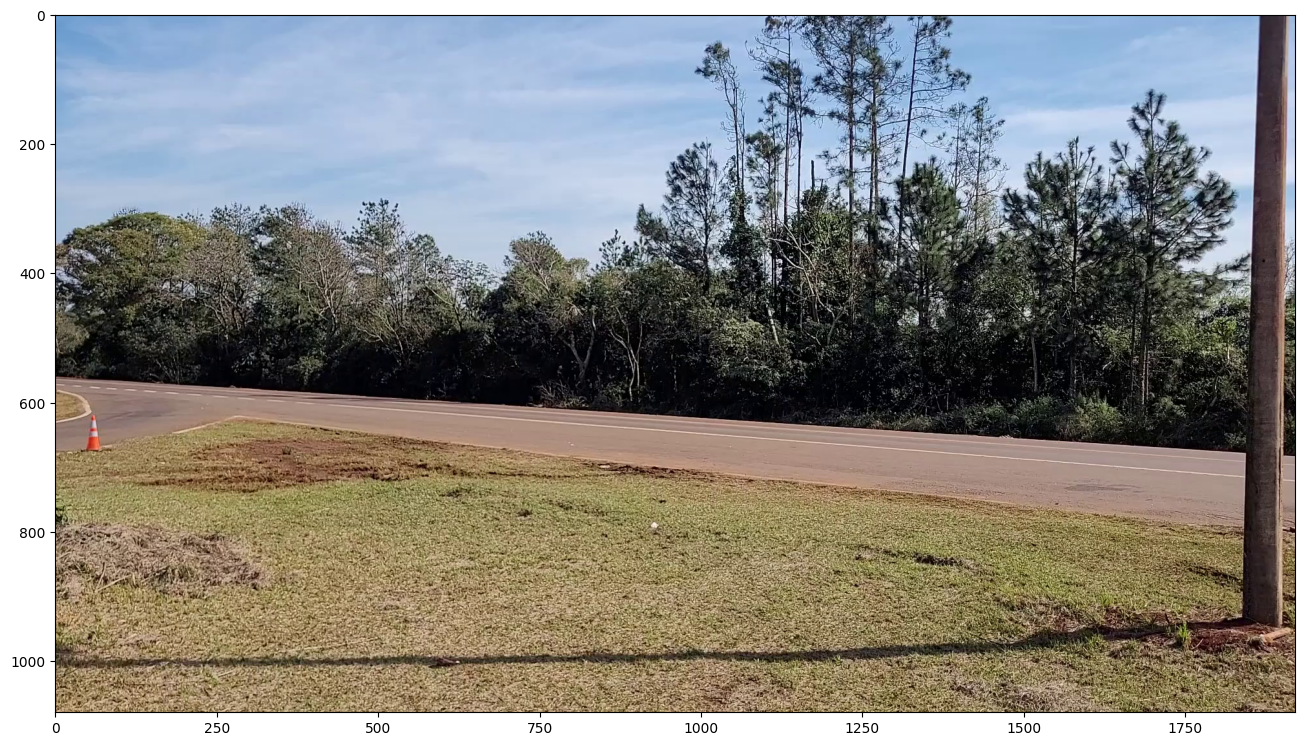

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Predict and annotate whole video

In [ ]:
# settings
LINE_START = Point(960, 0)
LINE_END = Point(960, 1080)

%cd {HOME}
SOURCE_VIDEO_PATH = f"/content/video/videovehiculos.mp4"
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
TARGET_VIDEO_PATH = f"/content/video_clasificados.mp4"

/content


In [ ]:
! pip install tqdm
!pip install opencv-python-headless


**CLASIFICACION DEL VIDEO + CLASE**

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import supervision as sv
import cv2
np.float = float  # Solución temporal para compatibilidad

# Crear una instancia de BYTETracker
byte_tracker = BYTETracker(BYTETrackerArgs())

# Crear una instancia de VideoInfo
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Crear un generador de frames del video
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)


# Crear una instancia de LineCounter
line_counter = LineCounter(start=LINE_START, end=LINE_END)

# Crear instancias de BoxAnnotator y LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=2, text_scale=1)

# Diccionario para almacenar el tracker_id, su clase y el lado tocado
vehicle_tracker_info = {}
total_vehicles=0


# Abrir el archivo de video de salida
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # Iterar sobre los frames del video
    for frame in tqdm(generator, total=video_info.total_frames):
        # Predicción del modelo en un solo frame y conversión a supervisión de detecciones
        results = model(frame, iou=0.6, verbose=False) # El parámetro verbose permite ocultar la salida en pantalla
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )

        # Seguimiento de detecciones
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # Formatear etiquetas personalizadas solo para detecciones con confianza superior al 50%
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id in detections if confidence > 0.5  # Solo agregar las detecciones con > 80% de confianza
        ]

        # Almacenar la clase asociada a cada tracker_id solo si la confianza es mayor al 90%
        for _, confidence, class_id, tracker_id in detections:
            if confidence > 0.9:  # Solo almacenar si la confianza es mayor al 90%
                if tracker_id not in vehicle_tracker_info:
                    vehicle_tracker_info[tracker_id] = {"class": CLASS_NAMES_DICT[class_id], "side": ""}
                    total_vehicles += 1  # Incrementar el contador total de vehículos

         # Actualizar el contador de línea
        line_counter.update(detections=detections)

        # Anotar y mostrar el frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)

        # Escribir el frame en el archivo de video de salida
        sink.write_frame(frame)

# Al finalizar el procesamiento de frames, exportar los datos a un archivo de texto
with open("vehicle_tracker_info.txt", "w") as f:
    # Escribir el total de vehículos detectados
    f.write(f"\Total de vehículos detectados: {total_vehicles}\n")

    for tracker_id, vehicle_data in vehicle_tracker_info.items():
        f.write(f"Tracker ID: #{tracker_id}, Clase: {vehicle_data['class']}\n")

print("Información de vehículos exportada a 'vehicle_tracker_info.txt' con el resumen de clases y total de vehículos.")


  0%|          | 0/2604 [00:00<?, ?it/s]

Información de vehículos exportada a 'vehicle_tracker_info.txt' con el resumen de clases y total de vehículos.


**VIDEO + CLASE + DIRECCION**

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import supervision as sv
np.float = float  # Solución temporal para compatibilidad

argumentos = BYTETrackerArgs(
    track_thresh=0.7,
    track_buffer=40,  # Aumentamos para evitar que se pierdan IDs por oclusión
    match_thresh=0.60,
    aspect_ratio_thresh=3.0,
    min_box_area=10.0,
    mot20=False
)

# Crear una instancia de BYTETracker
byte_tracker = BYTETracker(argumentos)

# Crear una instancia de VideoInfo
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Crear un generador de frames del video
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# Crear una instancia de LineCounter
line_counter = LineCounter(start=LINE_START, end=LINE_END)

# Crear instancias de BoxAnnotator y LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Diccionario para almacenar el tracker_id, su clase y el lado tocado
vehicle_tracker_info = {}

# Diccionario para contar la cantidad de vehículos por clase y lado tocado
class_counter = {class_name: {"izquierda": 0, "derecha": 0} for class_name in CLASS_NAMES_DICT.values()}

# Contador total de vehículos
total_vehicles = 0

#Contador de frames
frames=0

# Abrir el archivo de video de salida
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
     # Iterar sobre los frames del video
    for frame in tqdm(generator, total=video_info.total_frames):
        # Predicción del modelo en un solo frame y conversión a supervisión de detecciones
        results = model(frame, iou=0.6, verbose=False) # El parámetro verbose permite ocultar la salida en pantalla
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # Filtrar detecciones con clases no deseadas
      #  mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
      #  detections.filter(mask=mask, inplace=True)

        # Seguimiento de detecciones
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )

        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)

        detections.tracker_id = np.array(tracker_id)

        # Filtrar detecciones sin identificador de seguimiento
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # Formatear etiquetas personalizadas solo para detecciones con confianza superior al 50%
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id in detections if confidence > 0.1   # Solo agregar las detecciones con > 80% de confianza
                ]
        # Almacenar la clase asociada a cada tracker_id solo si la confianza es mayor al 90%
        for _, confidence, class_id, tracker_id in detections:
            if confidence > 0.9:  # Solo almacenar si la confianza es mayor al 90%
                if tracker_id not in vehicle_tracker_info:
                    vehicle_tracker_info[tracker_id] = {"class": CLASS_NAMES_DICT[class_id], "side": ""}
                    total_vehicles += 1  # Incrementar el contador total de vehículos

        # Verificar qué parte del vehículo toca primero la línea vertical
        for i, (_, confidence, class_id, tracker_id) in enumerate(detections):
            if confidence > 0.9:  # Solo considerar detecciones con alta confianza
                x_min, y_min, x_max, y_max = detections.xyxy[i]

                # Verificar si es la parte derecha o izquierda del vehículo la que toca la línea
                if x_max > LINE_START.x:
                    # Parte derecha toca primero
                    if vehicle_tracker_info[tracker_id]["side"] == "":
                        vehicle_tracker_info[tracker_id]["side"] = "derecha"
                        class_counter[CLASS_NAMES_DICT[class_id]]["derecha"] += 1
                elif x_min < LINE_START.x:
                    # Parte izquierda toca primero
                    if vehicle_tracker_info[tracker_id]["side"] == "":
                        vehicle_tracker_info[tracker_id]["side"] = "izquierda"
                        class_counter[CLASS_NAMES_DICT[class_id]]["izquierda"] += 1

        # Actualizar el contador de línea
        line_counter.update(detections=detections)

        # Anotar y mostrar el frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)

        # Escribir el frame en el archivo de video de salida
        sink.write_frame(frame)

# Al finalizar el procesamiento de frames, exportar los datos a un archivo de texto
with open("vehicle_tracker_info.txt", "w") as f:
  # Escribir el total de vehículos detectados
    f.write(f"Total de vehículos detectados: {total_vehicles}\n")
    for tracker_id, vehicle_data in vehicle_tracker_info.items():
        f.write(f"Tracker ID: #{tracker_id}, Clase: {vehicle_data['class']}, Direccion: {vehicle_data['side']}\n")

    # Escribir la cantidad total de vehículos por clase y lado tocado
    f.write("\nResumen total de vehículos por clase y direccion:\n")
    for class_name, sides in class_counter.items():
        f.write(f"{class_name} - Izquierda: {sides['izquierda']}, Derecha: {sides['derecha']}\n")


print("Información de vehículos exportada a 'vehicle_tracker_info.txt' con el resumen de clases y total de vehículos.")


  0%|          | 0/2604 [00:00<?, ?it/s]

Información de vehículos exportada a 'vehicle_tracker_info.txt' con el resumen de clases y total de vehículos.


In [ ]:
args = BYTETrackerArgs()
print(vars(args))  # Muestra los valores de los parámetros


{'track_thresh': 0.25, 'track_buffer': 30, 'match_thresh': 0.8, 'aspect_ratio_thresh': 3.0, 'min_box_area': 1.0, 'mot20': False}


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.